In [1]:
import os
import wandb
import copy 
import json

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

import analyse_results_utils

In [2]:
colors = ["r","g","b","y","b","c"]

In [3]:
api = wandb.Api()
jax_es_sweep = api.sweep("adam_katona/uncategorized/jd18zi1o") 
sweep_runs = list(jax_es_sweep.runs)


In [4]:
len(sweep_runs)

540

In [5]:
all_runs = []
failed_runs = []
for i,wanddb_run in enumerate(sweep_runs):
    if i%40 == 0:
        print(i,"/",len(sweep_runs))
    run_logs = wanddb_run.history()
    if len(run_logs) == 0:
        failed_runs.append(wanddb_run.config)
    else:
        run = {
            "wandb_run" : wanddb_run,
            "run_logs" : run_logs,
            "config" : wanddb_run.config,
            
        }
        all_runs.append(run)

0 / 540
40 / 540
80 / 540
120 / 540
160 / 540
200 / 540
240 / 540
280 / 540
320 / 540
360 / 540
400 / 540
440 / 540
480 / 540
520 / 540


In [6]:
len(all_runs)

485

In [7]:
len(failed_runs)

55

In [8]:
def id_to_path(id):
    from glob import glob    
    path = glob("/scratch/ak1774/runs/large_files_jax/*"+id, recursive = False)[0]
    return path

In [9]:
# Add path and load rollout results
for i,run in enumerate(all_runs):
    if i%40 == 0:
        print(i,"/",len(all_runs))
    run_id = run["wandb_run"].dir.split("/")[-1]
    run["path"] = id_to_path(run_id)
    
    rollout_arrays = np.load(run["path"]+"/final_rollout_arrays.npz",allow_pickle=True)["arr_0"].item()
    run["rollout_results"] = rollout_arrays

0 / 485
40 / 485
80 / 485
120 / 485
160 / 485
200 / 485
240 / 485
280 / 485
320 / 485
360 / 485
400 / 485
440 / 485
480 / 485


In [10]:
# load all the stuff
for i,run in enumerate(all_runs):
    if i%40 == 0:
        print(i,"/",len(all_runs))
    run["b_map_evolver"] = np.load(run["path"]+"/b_map_evolver.npy",allow_pickle=True)
    run["b_map_performance"] = np.load(run["path"]+"/b_map_performance.npy",allow_pickle=True)
    run["b_archive"] = np.load(run["path"]+"/b_archive.npy")


0 / 485


FileNotFoundError: [Errno 2] No such file or directory: '/scratch/ak1774/runs/large_files_jax/run-20220417_202624-mt3gawje/b_map_evolver.npy'

In [52]:
print(all_runs[0].keys())
print(all_runs[0]["run_logs"].keys())
print(all_runs[0]["rollout_results"].keys())

dict_keys(['wandb_run', 'run_logs', 'config', 'path', 'rollout_results'])
Index(['contact_cumm_nonempty_ratio', 'max_control_cost', 'mean_control_cost',
       'innovation', '_step', 'eval_control_cost', 'contact_nonempty_ratio',
       'evo_ent', '_runtime', 'pos_nonempty_ratio', 'eval_mean_dist',
       'pos_cumm_nonempty_ratio', 'pos_cumm_qd_score', 'eval_normal_fitness',
       'mean_dist', 'pos_qd_score', 'mean_normal_fitness',
       'contact_cumm_qd_score', 'evaluations_so_far', 'contact_qd_score',
       'generation_number', 'max_dist', 'evo_var', '_timestamp'],
      dtype='object')
dict_keys(['control_cost_fitness', 'forward_fitness', 'distance_walked', 'normal_fitness', 'final_pos', 'foot_contacts', 'directional_fitness', 'fitnesses', 'bds'])


In [54]:
# What do i want to plot?
# let us plot the learning curves for each env type and fitness type

# for this i need to group runs buy several keys.

("s",2) == ("s",3)



False

In [11]:
# now some functions which can do this with multiple keys
def get_unique_combinations(runs,keys):
    all_tuples = []
    for run in runs:
        all_tuples.append(tuple(run["config"][key] for key in keys))
    return set(all_tuples)

def select_where_keys_are(runs,keys,key_values):
    selected_runs = []
    for run in runs:
        if tuple(run["config"][key] for key in keys) == key_values:
            selected_runs.append(run)
    return selected_runs
    
def group_by_keys(runs,keys):
    unique_vals = get_unique_combinations(runs,keys)
    return {val:select_where_keys_are(runs,keys,val) for val in unique_vals}

# group runs togeather which have same config but different run_id
def group_runs_with_same_conf(runs):
    grouped_runs = {}
    for run in runs:
        run_conf = copy.deepcopy(run["config"])
        run_conf["RUN_ID"] = 0
        run_conf = json.dumps(run_conf)
        if run_conf in grouped_runs:
            grouped_runs[run_conf].append(run)
        else:
            grouped_runs[run_conf] = [run]
    return grouped_runs

In [12]:
grouped_runs = group_by_keys(all_runs,["env_name","env_mode"])
# sort
grouped_runs = {k: grouped_runs[k] for k in sorted(grouped_runs,key=lambda x: x[0])}
grouped_runs = {k: group_runs_with_same_conf(grouped_runs[k]) for k in grouped_runs}

In [13]:
for a,b in grouped_runs.items():
    print(a,len(b))

('ant', 'NORMAL_CONTACT') 10
('ant', 'DISTANCE_CONTACT') 9
('ant', 'DISTANCE_FINAL_POS') 9
('ant', 'DIRECTIONAL_CONTACT') 9
('ant', 'CONTROL_FINAL_POS') 9
('ant', 'NORMAL_FINAL_POS') 9
('halfcheetah', 'NORMAL_FINAL_POS') 9
('halfcheetah', 'NORMAL_CONTACT') 9
('halfcheetah', 'DISTANCE_CONTACT') 9
('halfcheetah', 'DISTANCE_FINAL_POS') 9
('halfcheetah', 'CONTROL_FINAL_POS') 9
('hopper', 'NORMAL_FINAL_POS') 9
('hopper', 'NORMAL_CONTACT') 9
('hopper', 'DISTANCE_CONTACT') 9
('hopper', 'DISTANCE_FINAL_POS') 9
('hopper', 'CONTROL_FINAL_POS') 9
('humanoid', 'NORMAL_CONTACT') 9
('humanoid', 'DISTANCE_CONTACT') 9
('humanoid', 'DISTANCE_FINAL_POS') 9
('humanoid', 'DIRECTIONAL_CONTACT') 9
('humanoid', 'CONTROL_FINAL_POS') 9
('humanoid', 'NORMAL_FINAL_POS') 9
('walker', 'CONTROL_FINAL_POS') 9
('walker', 'NORMAL_FINAL_POS') 9
('walker', 'NORMAL_CONTACT') 9
('walker', 'DISTANCE_CONTACT') 9
('walker', 'DISTANCE_FINAL_POS') 9


In [14]:
# Plot cummulative map staff

#################  eval_mean_dist
('ant', 'NORMAL_CONTACT')


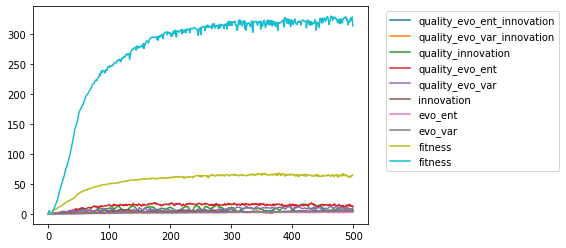

('ant', 'DISTANCE_CONTACT')


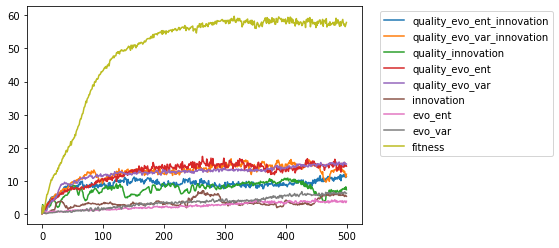

('ant', 'DISTANCE_FINAL_POS')


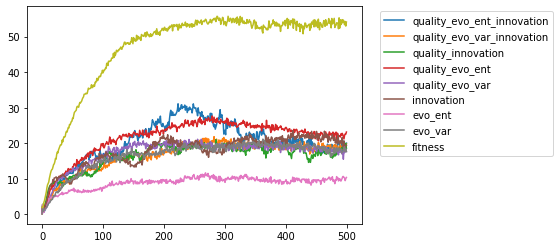

('ant', 'DIRECTIONAL_CONTACT')


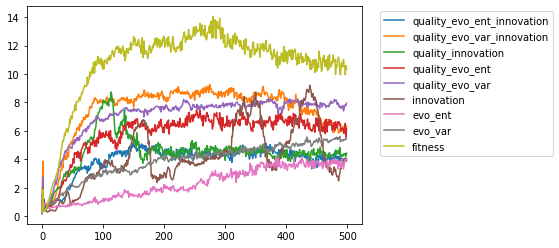

('ant', 'CONTROL_FINAL_POS')


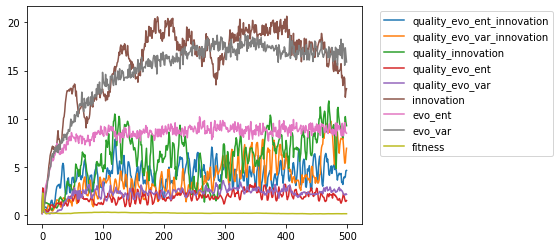

('ant', 'NORMAL_FINAL_POS')


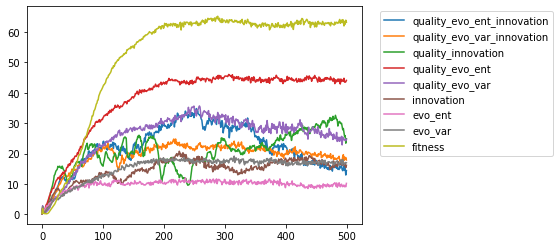

('halfcheetah', 'NORMAL_FINAL_POS')


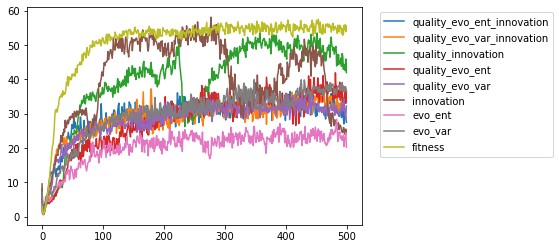

('halfcheetah', 'NORMAL_CONTACT')


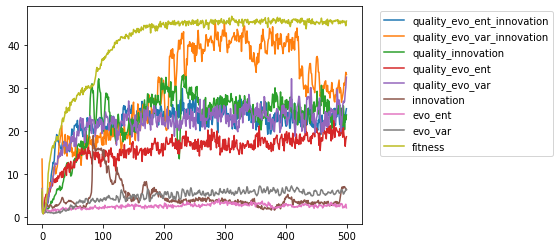

('halfcheetah', 'DISTANCE_CONTACT')


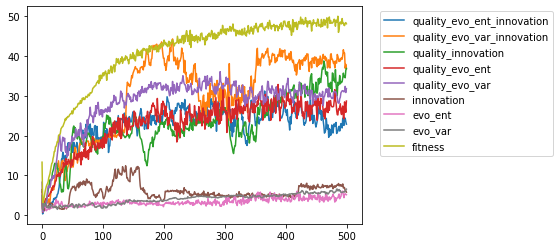

('halfcheetah', 'DISTANCE_FINAL_POS')


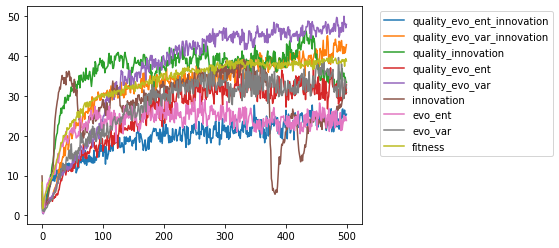

('halfcheetah', 'CONTROL_FINAL_POS')


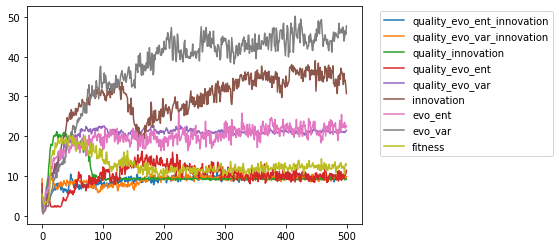

('hopper', 'NORMAL_FINAL_POS')


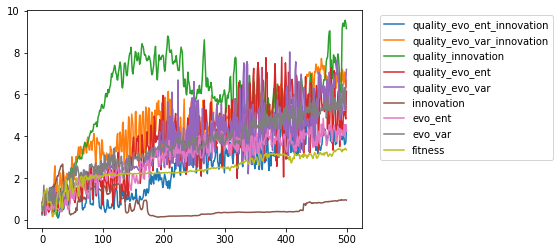

('hopper', 'NORMAL_CONTACT')


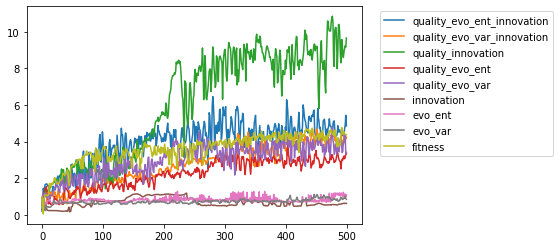

('hopper', 'DISTANCE_CONTACT')


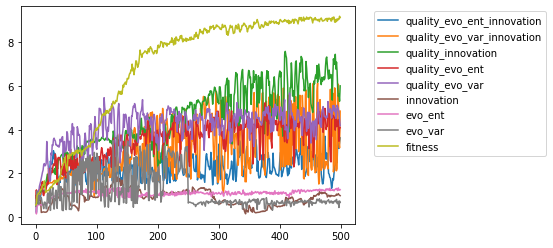

('hopper', 'DISTANCE_FINAL_POS')


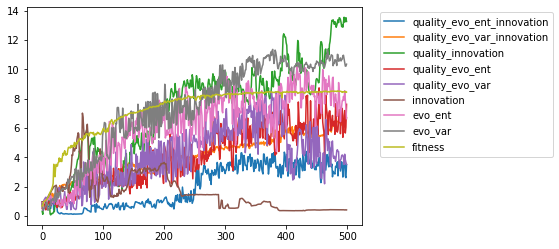

('hopper', 'CONTROL_FINAL_POS')


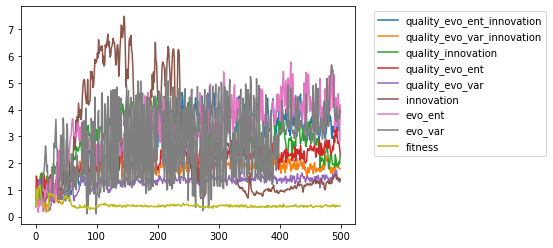

('humanoid', 'NORMAL_CONTACT')


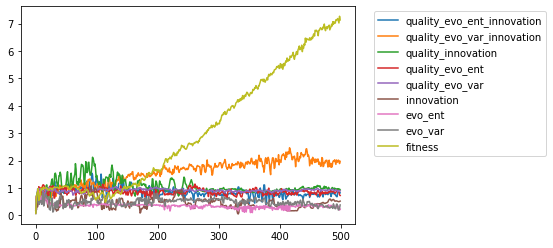

('humanoid', 'DISTANCE_CONTACT')


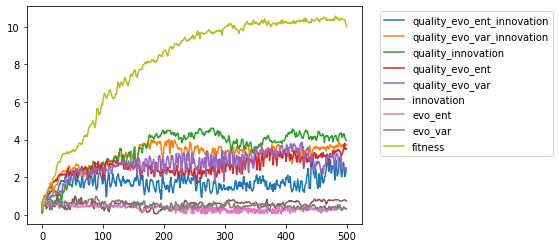

('humanoid', 'DISTANCE_FINAL_POS')


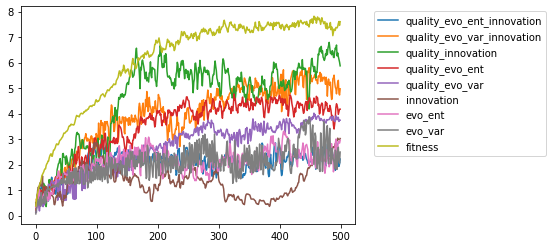

('humanoid', 'DIRECTIONAL_CONTACT')


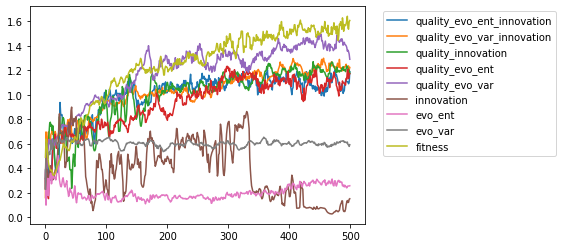

('humanoid', 'CONTROL_FINAL_POS')


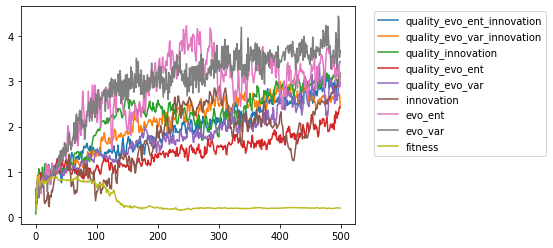

('humanoid', 'NORMAL_FINAL_POS')


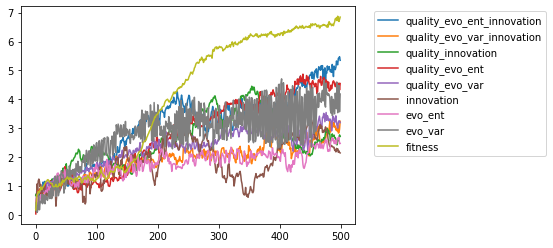

('walker', 'CONTROL_FINAL_POS')


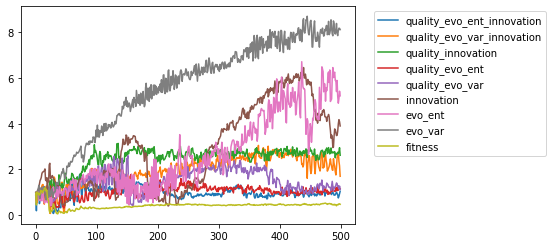

('walker', 'NORMAL_FINAL_POS')


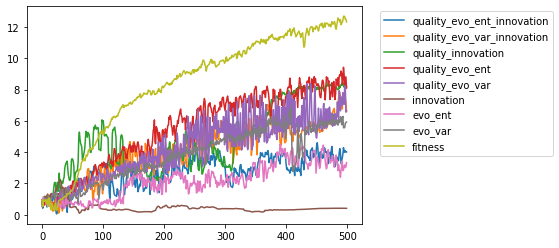

('walker', 'NORMAL_CONTACT')


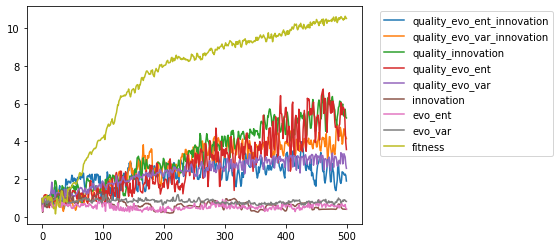

('walker', 'DISTANCE_CONTACT')


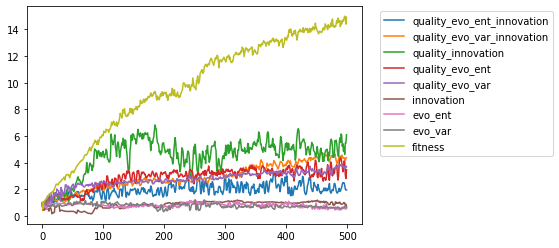

('walker', 'DISTANCE_FINAL_POS')


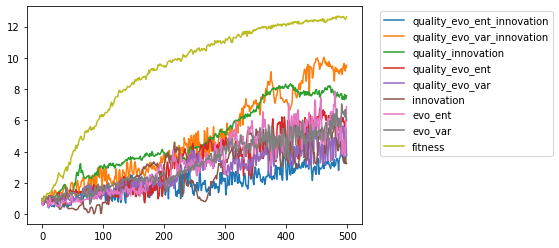

In [15]:
keys_to_plot = [
    #"eval_normal_fitness",
    "eval_mean_dist",
    #"max_dist",
    #"pos_cumm_nonempty_ratio",
    #"contact_cumm_nonempty_ratio",
]
for metric in keys_to_plot:
    print("################# ",metric)
    for env_tuple,runs_dict in grouped_runs.items():
        print(env_tuple)
        labels = []
        for run_list in runs_dict.values():
            curve_list = [run["run_logs"][metric] for run in run_list]
            curve = np.mean(np.stack(curve_list),axis=0)
            labels.append("".join(str(mode) for mode in run_list[0]["config"]["ES_UPDATES_MODES_TO_USE"]))
            plt.plot(curve)
        plt.legend(labels,bbox_to_anchor=(1.04,1))
        plt.show()
    